# **2-1. 스토킹 위험도 지수 예측**

---
> 1-2에서 학습한 설문조사 임베딩 모델을 기반으로 스토킹 잠재/가해자 분류 모델을 학습합니다.

> 해석을 최우선 목표로 하고 있기 때문에, 스토킹 잠재/가해 여부 판별에 있어 어떤 문항이 어느 정도 기여했는지, 어떤 문항의 어떤 단어들이 얼마나 기여했는지 Attention을 통해 학습니다.
---

In [1]:
# 드라이브 내 Custom Module 및 .ipynb 파일, 그리고 학습 데이터를 저장한 Directory를 입력하세요.
# 설문조사는 총 11개 문항으로 이루어져 있습니다. 학습을 원하는 문항의 번호를 입력하세요.

DIRECTORY = "AI경진대회" # 여기를 변경하세요.

## **(1) 라이브러리 준비**

In [ ]:
# Google Colab을 기반으로 학습을 진행할 경우, BERT 계열의 모델을 사용하기 위해 필요한 라이브러리를 설치합니다.

!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'
!pip install torchmetrics

In [3]:
import torch
import time
import os
import pickle
import random
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gluonnlp as nlp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertTokenizer, BertModel, AutoModel, AutoTokenizer
from kobert import get_pytorch_kobert_model

## **(2) Drive Mount 및 Custom Module 불러오기**

In [4]:
# Drive Mount
from google.colab import drive
drive.mount('/content/gdrive')

# Directory 변경
path = "/content/gdrive/My Drive/" + DIRECTORY
os.chdir(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
from dataset import Tester
from model import NewSE, Stalking, NewSE2, Predictor

## **(3) 데이터셋 불러오기**

In [7]:
# 데이터셋 준비

data = pd.read_csv('./DATA/Luv.D/경진대회 데이터_수정본.csv')

In [8]:
# Train/Valid 데이터에 대해 Label Encoding

temp = []

for i in range(data.shape[0]):
    if (data.loc[i, 'warning'] == 1) or (data.loc[i, 'warning'] == 2):
        temp.append(1)
    else:
        temp.append(0)

data['warning'] = temp

temp = []

for i in range(data.shape[0]):
    if data.loc[i, 'status'] == '상':
        temp.append(2)
    elif data.loc[i, 'status'] == '하':
        temp.append(1)
    else:
        temp.append(0)

data['status'] = temp

In [9]:
data = data.dropna(axis=0).reset_index(drop=True)
data.shape

(8725, 14)

## **(4) KcELECTRA, Tokenizer 불러오기**

In [10]:
# KcELECTRA, Tokenizer

tokenizer = AutoTokenizer.from_pretrained("beomi/KcELECTRA-base-v2022")
kc_model = AutoModel.from_pretrained("beomi/KcELECTRA-base-v2022")

kc_model = kc_model.cuda()

Some weights of the model checkpoint at beomi/KcELECTRA-base-v2022 were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## **(5) DataLoader 준비**

In [11]:
# Dataset

dataset = Tester(tokenizer=tokenizer, embed_model=kc_model, data=data)#, device=device)

In [12]:
# DataLoader

BATCH_SIZE=64

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

## **(6) 모델 생성**

In [13]:
# Model (정신건강 분류)

mentality_model = NewSE2(num_layers=2,
                         embedding_size=768,
                         hidden_size=384,
                         attention_dim=512,
                         keys=30,
                         fc_dim=512,
                         batch_size=25)

mentality_model.load_state_dict(torch.load('./TRAINED_MODEL/MENTAL/mentality_test.pt', map_location=device))

<All keys matched successfully>

In [14]:
# Model (Classifier)

stalking_model = Stalking(device=device, model_path='./TRAINED_MODEL/SE', batch_size=64)
stalking_model.load_state_dict(torch.load('./TRAINED_MODEL/Classifier/stalking_detection.pt'))

<All keys matched successfully>

In [15]:
# 스토킹 위험도 지수 출력 Class

validate = Predictor(mentality_model=mentality_model,
                     stalking_model=stalking_model,
                     batch_size=BATCH_SIZE)

## **(7) 스토킹 위험 지수 확인**

In [ ]:
final = []

for i, dict in enumerate(dataloader):
    last = dict['last'].to(device=device, dtype=torch.float32)
    reason = dict['reason'].to(device=device, dtype=torch.float32)
    action = dict['action'].to(device=device, dtype=torch.float32)
    try_ = dict['try'].to(device=device, dtype=torch.float32)
    reaction = dict['reaction'].to(device=device, dtype=torch.float32)
    charmingCustomer = dict['charmingCustomer'].to(device=device, dtype=torch.float32)
    relation = dict['relation'].to(device=device, dtype=torch.float32)
    targets = dict['target'].to(device=device, dtype=torch.int32)

    result = validate.predict(last, reason, action, try_, reaction, charmingCustomer, relation)
    
    final.extend(result.squeeze(1).cpu().detach().numpy().tolist())

## **(8) 학습 결과 시각화**

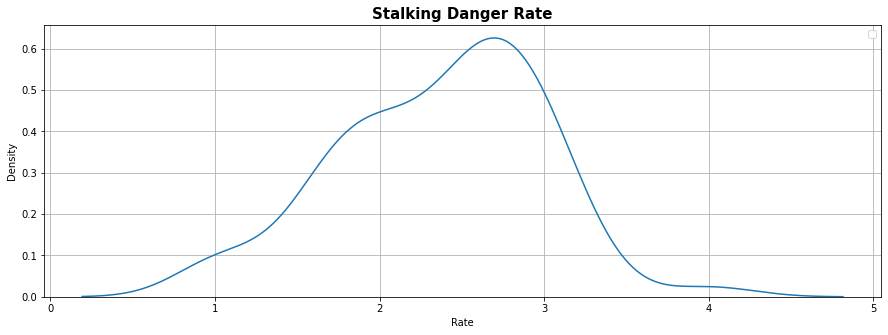

In [22]:
# 시각화

f, ax = plt.subplots(figsize=(15, 5))
plt.title("Stalking Danger Rate", fontsize=15, weight='bold')
plt.xlabel('Rate')
sns.kdeplot(final)
plt.legend()
plt.grid(True)